# Artificial Neural Networks and Deep Learning

---

## Homework 2: Bio.log(y)

### Model 1: base U-Net

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 2


## ⏳ Load the Data

In [2]:
# Load the compressed dataset
data = np.load("/kaggle/input/mydatasets-base/mars_datasets_base.npz")

# Extract the individual arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_our_test = data["X_our_test"]
y_our_test = data["y_our_test"]
X_test = data["X_test"]

# Print shapes to verify successful loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1503, 64, 128, 1)
y_train shape: (1503, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


## 🛠️ Train and Save the Model

In [3]:
input_shape = (64, 128, 1)  
num_classes = len(np.unique(y_train)) 

In [4]:
# Number of training epochs
epochs = 200

# Batch size for training
batch_size = 32

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)

Epochs: 200
Batch Size: 32


In [5]:
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    label = np.asarray(label).squeeze()

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [6]:
# Define custom Mean Intersection Over Union metric with subsampling
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Subsample every 10th value to reduce memory usage
        indices = tf.range(start=0, limit=tf.shape(y_true)[0], delta=10)
        y_true = tf.gather(y_true, indices)
        y_pred = tf.gather(y_pred, indices)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes, frequency=5):
        super().__init__()
        self.image = image
        self.label = label  # Assumiamo che `label` sia già un array NumPy
        self.num_classes = num_classes
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epoche
            pred = self.model.predict(tf.expand_dims(self.image, axis=0), verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)  # Rimosso `.numpy()`
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [7]:
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Exclude the background class
    y_true = y_true[..., 1:]  
    y_pred = y_pred[..., 1:]  

    # Clip predictions
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    weights = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weights * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))


def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    # Exclude the background class
    y_true = y_true[..., 1:] 
    y_pred = y_pred[..., 1:]  

    # Intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Dice loss
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)


def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return focal_weight * f_loss + dice_weight * d_loss

In [8]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    x = input_tensor
    for i in range(stack):  
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + f'conv{i+1}')(x)
        x = tfkl.BatchNormalization(name=name + f'bn{i+1}')(x)
        x = tfkl.Activation(activation, name=name + f'activation{i+1}')(x)
    return x

In [9]:
def get_unet_model(input_shape=input_shape, num_classes=num_classes):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path (Encoder)
    down_block_1 = unet_block(input_layer, filters=32, name='down_block1_')  # Primo blocco encoder
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, filters=64, name='down_block2_')  # Secondo blocco encoder
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, filters=128, stack = 3, name='bottleneck')

    # Upsampling path (Decoder)
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, filters=64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, filters=32, name='up_block2_')

    # Output layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    # Modello finale
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv1 │ (None, 64, 128, │       320 │ input_layer[0… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn1   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_conv2 │ (None, 64, 128, │     9,248 │ down_block1_a… │   Y   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_bn2   │ (None, 64, 128, │       128 │ down_block1_c… │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block1_acti… │ (None, 64, 128, │         0 │ down_block1_b… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ down_block1_a… │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv1 │ (None, 32, 64,  │    18,496 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn1   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_conv2 │ (None, 32, 64,  │    36,928 │ down_block2_a… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_bn2   │ (None, 32, 64,  │       256 │ down_block2_c… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ down_block2_acti… │ (None, 32, 64,  │         0 │ down_block2_b… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_1   │ (None, 16, 32,  │         0 │ down_block2_a… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckconv1   │ (None, 16, 32,  │    73,856 │ max_pooling2d… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ bottleneckbn1     │ (None, 16, 32,  │       512 │ bottleneckcon… │   Y 

 Total params: 621,765 (2.37 MB)

 Trainable params: 620,229 (2.37 MB)

 Non-trainable params: 1,536 (6.00 KB)

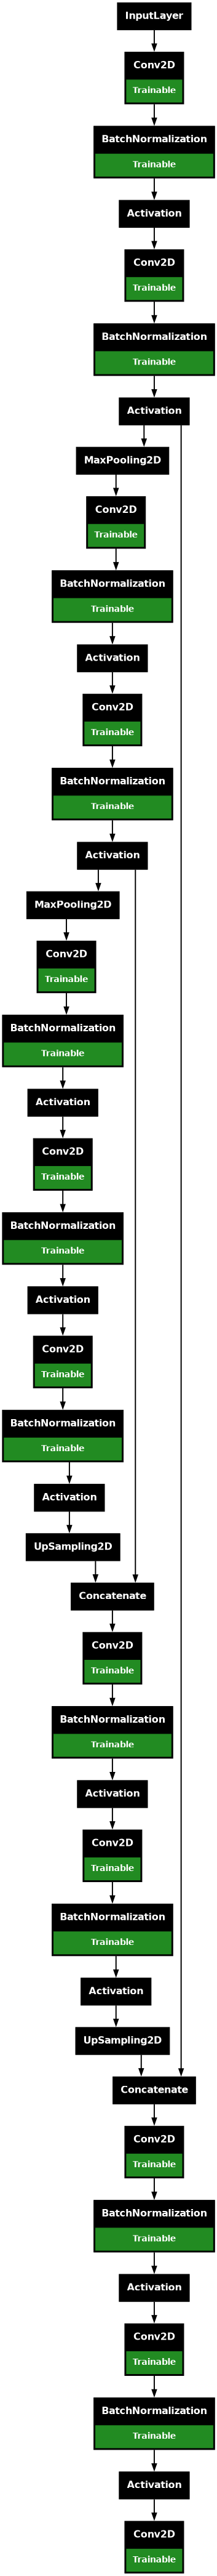

In [10]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [11]:
model.compile(optimizer="adam", 
               loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8), 
              metrics=["accuracy", 
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

model.summary()

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv1   │ (None, 64, 128,   │        320 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn1     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn1[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_conv2   │ (None, 64, 128,   │      9,248 │ down_block1_acti… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_bn2     │ (None, 64, 128,   │        128 │ down_block1_conv… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block1_activa… │ (None, 64, 128,   │          0 │ down_block1_bn2[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ down_block1_acti… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv1   │ (None, 32, 64,    │     18,496 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn1     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn1[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_conv2   │ (None, 32, 64,    │     36,928 │ down_block2_acti… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_bn2     │ (None, 32, 64,    │        256 │ down_block2_conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ down_block2_activa… │ (None, 32, 64,    │          0 │ down_block2_bn2[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ down_block2_acti… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneckconv1     │ (None, 16, 32,    │     73,856 │ max_pooling2d_1[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneckbn1       │ (None, 16, 32,    │        512 │ bottleneckconv1[

 Total params: 621,765 (2.37 MB)

 Trainable params: 620,229 (2.37 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [12]:
def scheduler(epoch):
    # Parametri
    warmup_epochs = 5  # Numero di epoche di warm-up
    plateau_epochs = 3  # Numero di epoche a learning rate costante
    initial_lr = 1e-3  # Learning rate iniziale
    min_lr = 1e-6  # Learning rate minimo
    total_epochs = 200  # Numero totale di epoche

    if epoch < warmup_epochs:
        # Fase di warm-up
        return float((epoch + 1) / warmup_epochs * initial_lr)
    elif epoch < warmup_epochs + plateau_epochs:
        # Fase di plateau
        return float(initial_lr)
    else:
        # Fase di cosine annealing
        return float(min_lr + 0.5 * (initial_lr - min_lr) * 
                     (1 + tf.math.cos((epoch - warmup_epochs - plateau_epochs) / 
                                      (total_epochs - warmup_epochs - plateau_epochs) * 3.14159)))

In [13]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_mean_iou',       
    mode='max',                   
    patience=20,                  
    restore_best_weights=True     
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           
    factor=0.5,                   
    patience=5,                   
    verbose=1,                   
    min_lr=1e-6                   
)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


# Select a specific image and mask from the dataset
sample_idx = 42  
sample_image = X_train[sample_idx]
sample_mask = y_train[sample_idx]

# Initialize the VizCallback with the selected image and mask
viz_callback = VizCallback(
    image=sample_image,
    label=sample_mask,
    num_classes=num_classes,
    frequency=5
)

Epoch 1/200


I0000 00:00:1734202049.430908      93 service.cc:145] XLA service 0x7e533802a7b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734202049.430963      93 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734202049.430967      93 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 2/47 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.2312 - loss: 0.3409 - mean_iou: 0.1467  

I0000 00:00:1734202063.383109      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1734202063.397618      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3413 - loss: 0.2981 - mean_iou: 0.1829

I0000 00:00:1734202077.176587      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_3', 16 bytes spill stores, 16 bytes spill loads



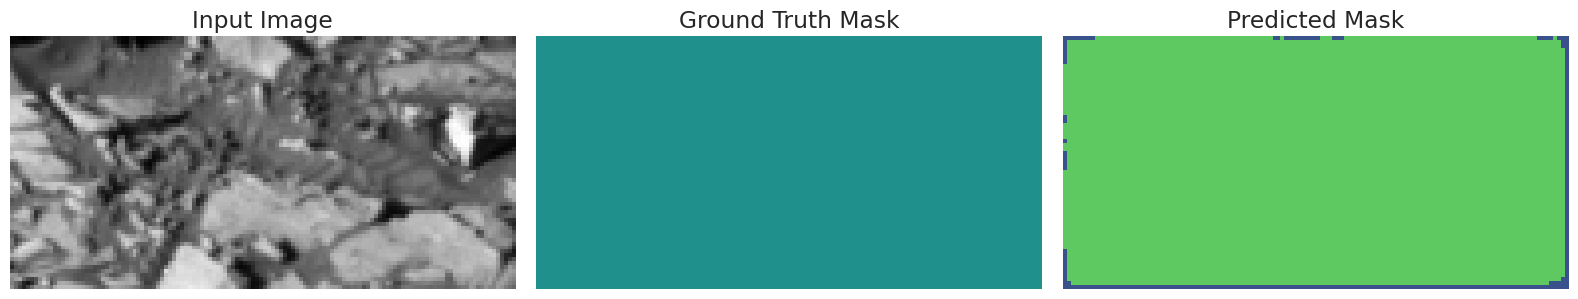

47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 459ms/step - accuracy: 0.3426 - loss: 0.2977 - mean_iou: 0.1836 - val_accuracy: 0.1873 - val_loss: 0.3625 - val_mean_iou: 0.0622 - learning_rate: 2.0000e-04
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.4934 - loss: 0.2389 - mean_iou: 0.2929 - val_accuracy: 0.1832 - val_loss: 0.4631 - val_mean_iou: 0.0573 - learning_rate: 4.0000e-04
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5133 - loss: 0.2250 - mean_iou: 0.3538 - val_accuracy: 0.1831 - val_loss: 0.7027 - val_mean_iou: 0.0571 - learning_rate: 6.0000e-04
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5081 - loss: 0.2199 - mean_iou: 0.2995 - val_accuracy: 0.1831 - val_loss: 0.6396 - val_mean_iou: 0.0572 - learning_rate: 8.0000e-04
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5267 - loss: 0.2154 - mean_iou: 0.4427 - val_accuracy: 0.1831 - val_loss: 0.7757 - val_mean_iou: 0.0571 - learning_rate: 0.0010
Epoch 6/200
47/47 ━━━━━━

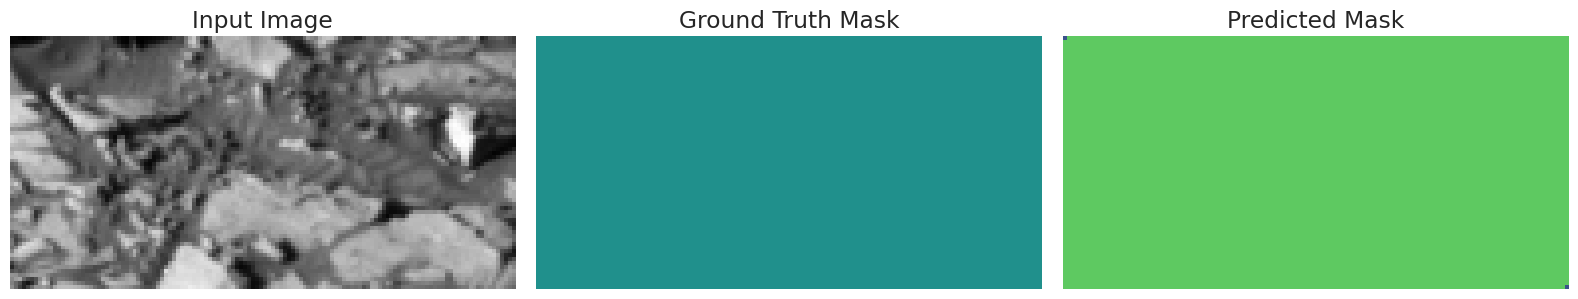

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5327 - loss: 0.2095 - mean_iou: 0.4453 - val_accuracy: 0.1830 - val_loss: 0.6832 - val_mean_iou: 0.0571 - learning_rate: 0.0010
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5564 - loss: 0.2052 - mean_iou: 0.5127 - val_accuracy: 0.1830 - val_loss: 0.6626 - val_mean_iou: 0.0571 - learning_rate: 0.0010
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5715 - loss: 0.1994 - mean_iou: 0.5578 - val_accuracy: 0.1847 - val_loss: 0.5530 - val_mean_iou: 0.0617 - learning_rate: 0.0010
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.5809 - loss: 0.1966 - mean_iou: 0.5734 - val_accuracy: 0.1863 - val_loss: 0.5970 - val_mean_iou: 0.0648 - learning_rate: 0.0010
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.5845 - loss: 0.1980 - mean_iou: 0.5703 - val_accuracy: 0.2324 - val_loss: 0.5569 - val_mean_iou: 0.0974 - learning_rate: 9.9993e-04
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━

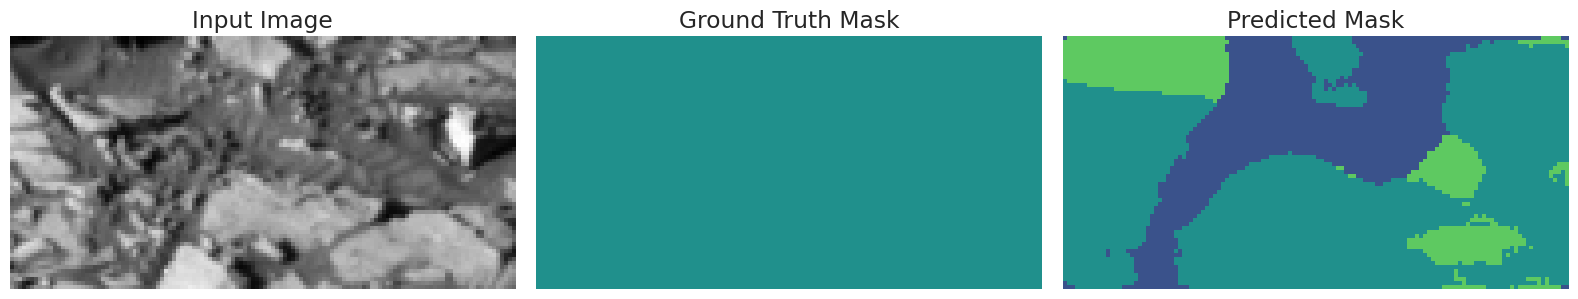

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.5876 - loss: 0.1970 - mean_iou: 0.5682 - val_accuracy: 0.3325 - val_loss: 0.3384 - val_mean_iou: 0.1961 - learning_rate: 9.9973e-04
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6020 - loss: 0.1920 - mean_iou: 0.6035 - val_accuracy: 0.3427 - val_loss: 0.3845 - val_mean_iou: 0.2089 - learning_rate: 9.9940e-04
Epoch 13/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6083 - loss: 0.1904 - mean_iou: 0.5713 - val_accuracy: 0.4846 - val_loss: 0.2437 - val_mean_iou: 0.3425 - learning_rate: 9.9893e-04
Epoch 14/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6086 - loss: 0.1901 - mean_iou: 0.5879 - val_accuracy: 0.5573 - val_loss: 0.2187 - val_mean_iou: 0.3998 - learning_rate: 9.9833e-04
Epoch 15/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6023 - loss: 0.1908 - mean_iou: 0.5824 - val_accuracy: 0.5491 - val_loss: 0.2210 - val_mean_iou: 0.4033 - learning_rate: 9.9759e-04
Epoch 16/200
47/47

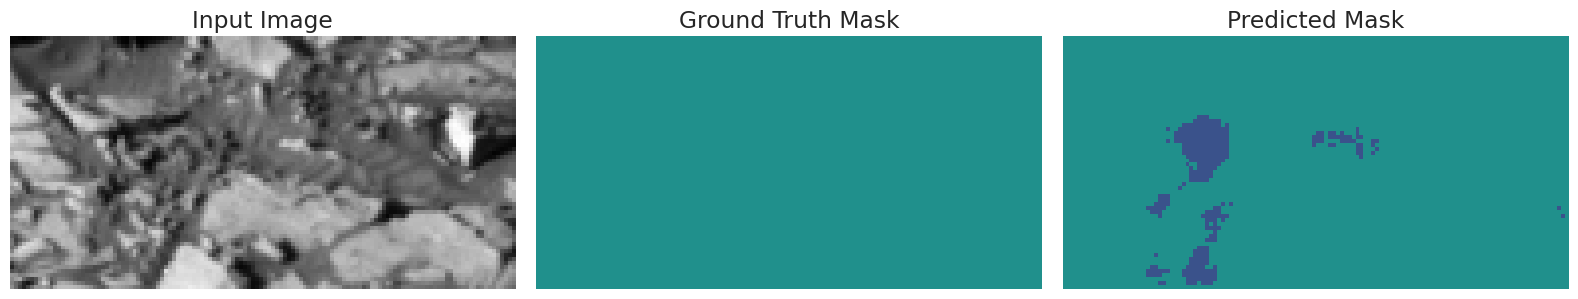

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.6163 - loss: 0.1872 - mean_iou: 0.6090 - val_accuracy: 0.5278 - val_loss: 0.2147 - val_mean_iou: 0.3871 - learning_rate: 9.9673e-04
Epoch 17/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6105 - loss: 0.1891 - mean_iou: 0.5988 - val_accuracy: 0.6101 - val_loss: 0.2006 - val_mean_iou: 0.4701 - learning_rate: 9.9573e-04
Epoch 18/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6219 - loss: 0.1862 - mean_iou: 0.6221 - val_accuracy: 0.5895 - val_loss: 0.2072 - val_mean_iou: 0.4564 - learning_rate: 9.9459e-04
Epoch 19/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6270 - loss: 0.1857 - mean_iou: 0.5804 - val_accuracy: 0.5828 - val_loss: 0.2023 - val_mean_iou: 0.4516 - learning_rate: 9.9333e-04
Epoch 20/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6232 - loss: 0.1842 - mean_iou: 0.6003 - val_accuracy: 0.5627 - val_loss: 0.2055 - val_mean_iou: 0.4469 - learning_rate: 9.9193e-04
Epoch 21/200
47/47

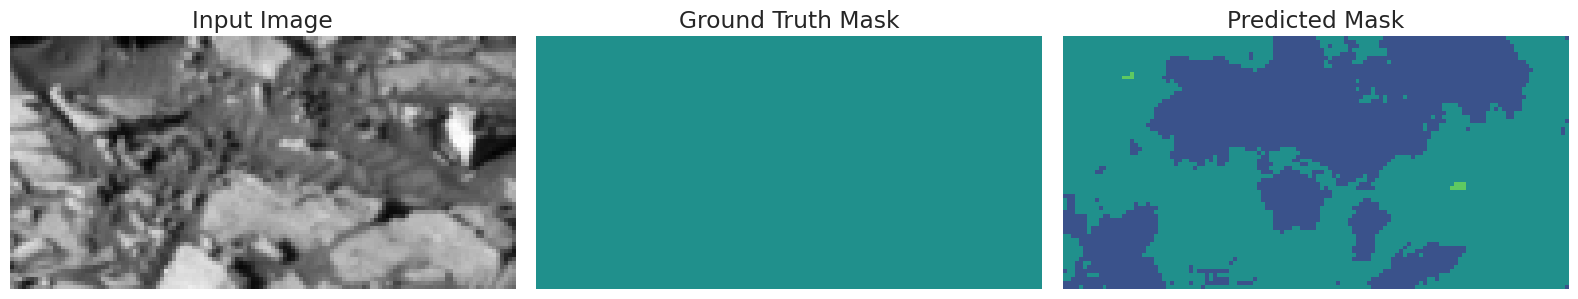

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6378 - loss: 0.1811 - mean_iou: 0.6512 - val_accuracy: 0.5470 - val_loss: 0.2114 - val_mean_iou: 0.3947 - learning_rate: 9.9040e-04
Epoch 22/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6342 - loss: 0.1822 - mean_iou: 0.6569
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0004943711683154106.
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6345 - loss: 0.1821 - mean_iou: 0.6557 - val_accuracy: 0.5804 - val_loss: 0.2108 - val_mean_iou: 0.4457 - learning_rate: 9.8874e-04
Epoch 23/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6356 - loss: 0.1816 - mean_iou: 0.6316 - val_accuracy: 0.5834 - val_loss: 0.1982 - val_mean_iou: 0.4605 - learning_rate: 9.8695e-04
Epoch 24/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6331 - loss: 0.1818 - mean_iou: 0.6213 - val_accuracy: 0.5760 - val_loss: 0.2081 - val_mean_iou: 0.4487 - learning_rate: 9.8503e-04
Epoch 25/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms

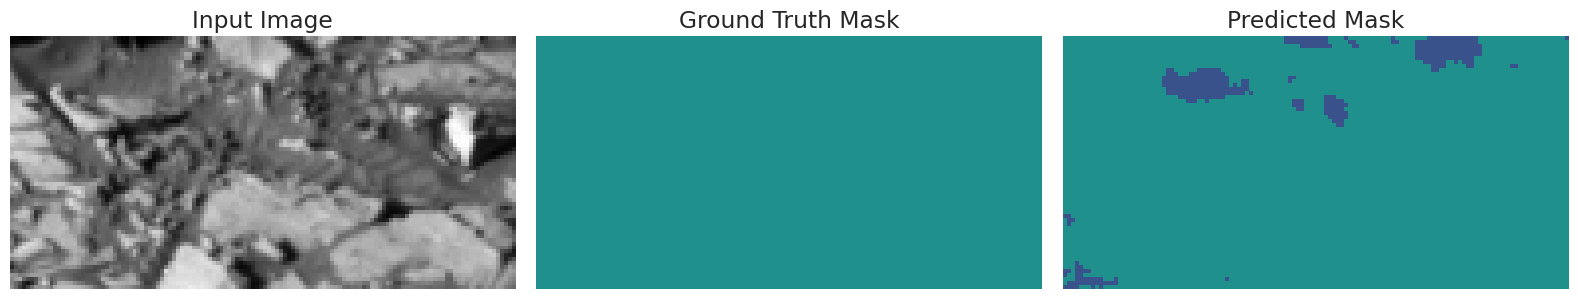

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6410 - loss: 0.1793 - mean_iou: 0.6466 - val_accuracy: 0.6048 - val_loss: 0.2039 - val_mean_iou: 0.4765 - learning_rate: 9.8080e-04
Epoch 27/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6431 - loss: 0.1792 - mean_iou: 0.6490 - val_accuracy: 0.6148 - val_loss: 0.1921 - val_mean_iou: 0.4841 - learning_rate: 9.7849e-04
Epoch 28/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6528 - loss: 0.1756 - mean_iou: 0.6056 - val_accuracy: 0.5739 - val_loss: 0.2083 - val_mean_iou: 0.4378 - learning_rate: 9.7606e-04
Epoch 29/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6553 - loss: 0.1753 - mean_iou: 0.6164 - val_accuracy: 0.5962 - val_loss: 0.1957 - val_mean_iou: 0.4684 - learning_rate: 9.7349e-04
Epoch 30/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6569 - loss: 0.1743 - mean_iou: 0.6752 - val_accuracy: 0.5527 - val_loss: 0.2066 - val_mean_iou: 0.4654 - learning_rate: 9.7080e-04
Epoch 31/200
47/47

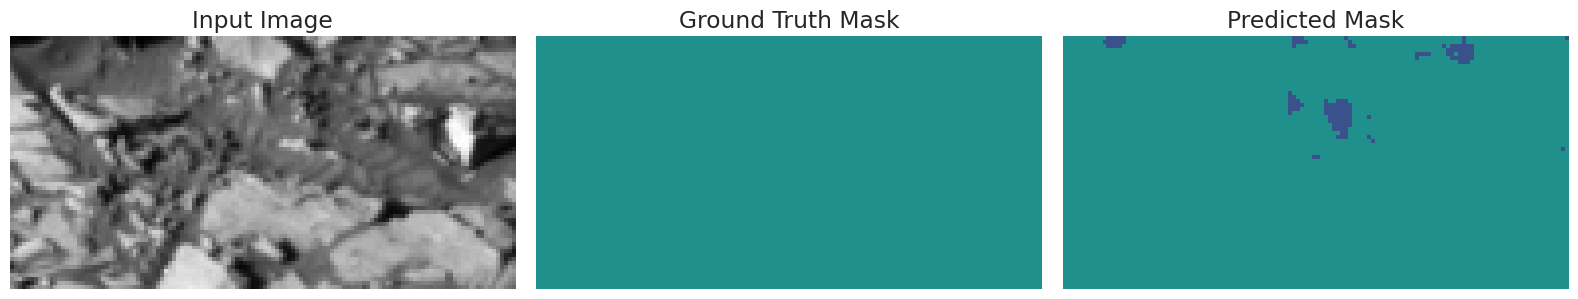

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.6580 - loss: 0.1732 - mean_iou: 0.6324 - val_accuracy: 0.6212 - val_loss: 0.1914 - val_mean_iou: 0.5180 - learning_rate: 9.6799e-04
Epoch 32/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6546 - loss: 0.1746 - mean_iou: 0.6451 - val_accuracy: 0.5632 - val_loss: 0.2423 - val_mean_iou: 0.4348 - learning_rate: 9.6504e-04
Epoch 33/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.6526 - loss: 0.1753 - mean_iou: 0.6921 - val_accuracy: 0.6342 - val_loss: 0.1952 - val_mean_iou: 0.4856 - learning_rate: 9.6198e-04
Epoch 34/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.6635 - loss: 0.1726 - mean_iou: 0.6426 - val_accuracy: 0.5321 - val_loss: 0.2303 - val_mean_iou: 0.4046 - learning_rate: 9.5879e-04
Epoch 35/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6656 - loss: 0.1709 - mean_iou: 0.6885 - val_accuracy: 0.6017 - val_loss: 0.2038 - val_mean_iou: 0.4744 - learning_rate: 9.5548e-04
Epoch 36/200
47/47

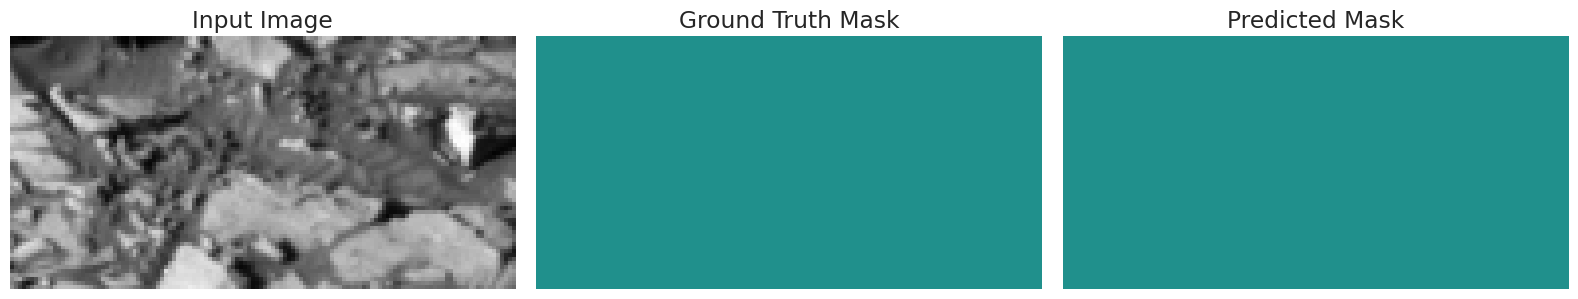

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.6639 - loss: 0.1735 - mean_iou: 0.7026 - val_accuracy: 0.5526 - val_loss: 0.2518 - val_mean_iou: 0.4112 - learning_rate: 9.5204e-04
Epoch 37/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6608 - loss: 0.1719 - mean_iou: 0.6344 - val_accuracy: 0.6374 - val_loss: 0.1951 - val_mean_iou: 0.5108 - learning_rate: 9.4849e-04
Epoch 38/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6729 - loss: 0.1696 - mean_iou: 0.6762 - val_accuracy: 0.6072 - val_loss: 0.1955 - val_mean_iou: 0.4748 - learning_rate: 9.4481e-04
Epoch 39/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6731 - loss: 0.1690 - mean_iou: 0.6840 - val_accuracy: 0.5876 - val_loss: 0.2027 - val_mean_iou: 0.4775 - learning_rate: 9.4102e-04
Epoch 40/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6753 - loss: 0.1680 - mean_iou: 0.6670 - val_accuracy: 0.6239 - val_loss: 0.2105 - val_mean_iou: 0.4928 - learning_rate: 9.3711e-04
Epoch 41/200
47/47

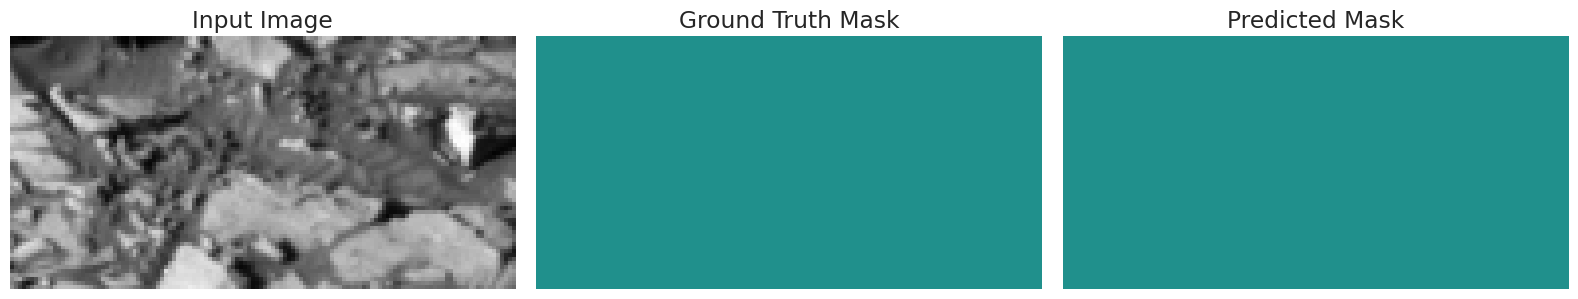

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.6778 - loss: 0.1675 - mean_iou: 0.6607 - val_accuracy: 0.5504 - val_loss: 0.2584 - val_mean_iou: 0.4030 - learning_rate: 9.3308e-04
Epoch 42/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6799 - loss: 0.1674 - mean_iou: 0.7620 - val_accuracy: 0.5911 - val_loss: 0.2203 - val_mean_iou: 0.4882 - learning_rate: 9.2894e-04
Epoch 43/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6783 - loss: 0.1686 - mean_iou: 0.6641 - val_accuracy: 0.5593 - val_loss: 0.2380 - val_mean_iou: 0.4550 - learning_rate: 9.2468e-04
Epoch 44/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6782 - loss: 0.1672 - mean_iou: 0.6772 - val_accuracy: 0.5871 - val_loss: 0.2135 - val_mean_iou: 0.4853 - learning_rate: 9.2030e-04
Epoch 45/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6787 - loss: 0.1673 - mean_iou: 0.7038 - val_accuracy: 0.5942 - val_loss: 0.2177 - val_mean_iou: 0.4647 - learning_rate: 9.1582e-04
Epoch 46/200
47/47

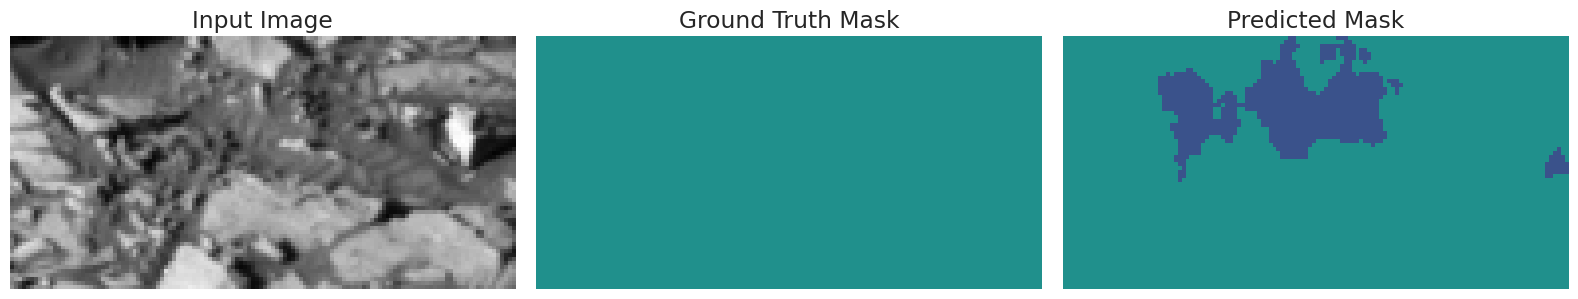

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.6873 - loss: 0.1658 - mean_iou: 0.6883 - val_accuracy: 0.6299 - val_loss: 0.2063 - val_mean_iou: 0.4861 - learning_rate: 9.1122e-04
Epoch 47/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.6830 - loss: 0.1654 - mean_iou: 0.7644 - val_accuracy: 0.5799 - val_loss: 0.2254 - val_mean_iou: 0.4544 - learning_rate: 9.0652e-04
Epoch 48/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6899 - loss: 0.1641 - mean_iou: 0.7422 - val_accuracy: 0.6345 - val_loss: 0.1918 - val_mean_iou: 0.5079 - learning_rate: 9.0170e-04
Epoch 49/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6938 - loss: 0.1632 - mean_iou: 0.7790 - val_accuracy: 0.6013 - val_loss: 0.2087 - val_mean_iou: 0.4541 - learning_rate: 8.9678e-04
Epoch 50/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6959 - loss: 0.1623 - mean_iou: 0.7425 - val_accuracy: 0.5804 - val_loss: 0.2055 - val_mean_iou: 0.4216 - learning_rate: 8.9175e-04
Epoch 51/200
47/47

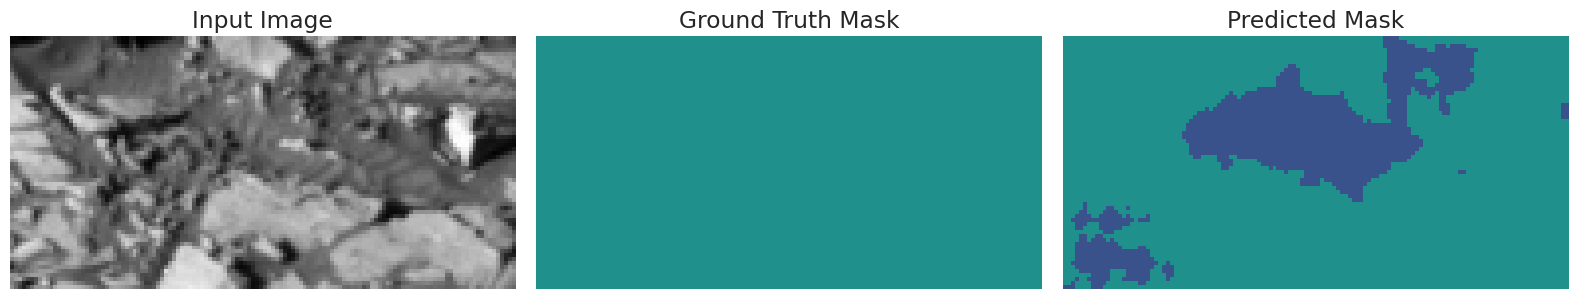

47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.6999 - loss: 0.1609 - mean_iou: 0.7227 - val_accuracy: 0.6322 - val_loss: 0.2088 - val_mean_iou: 0.5165 - learning_rate: 8.8662e-04


In [14]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, early_stopping, reduce_lr, viz_callback],
    verbose=1
).history

In [15]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 51.8%


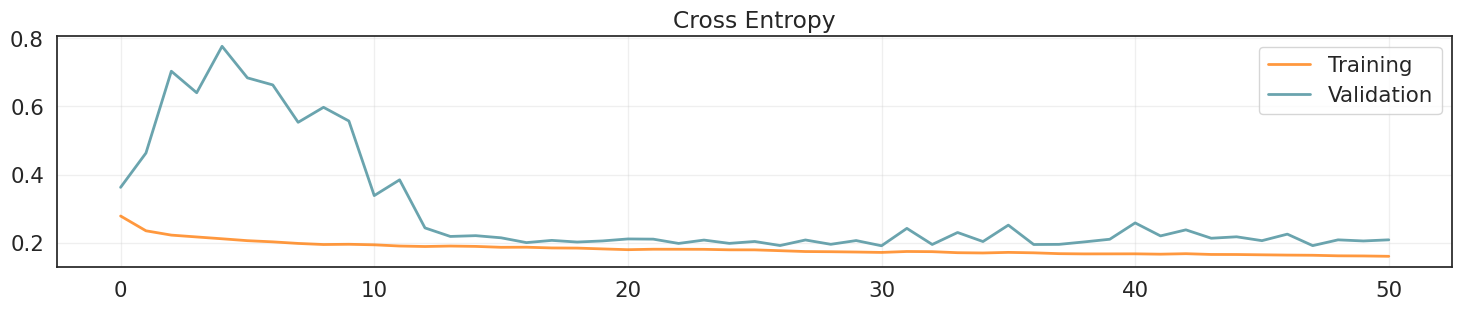

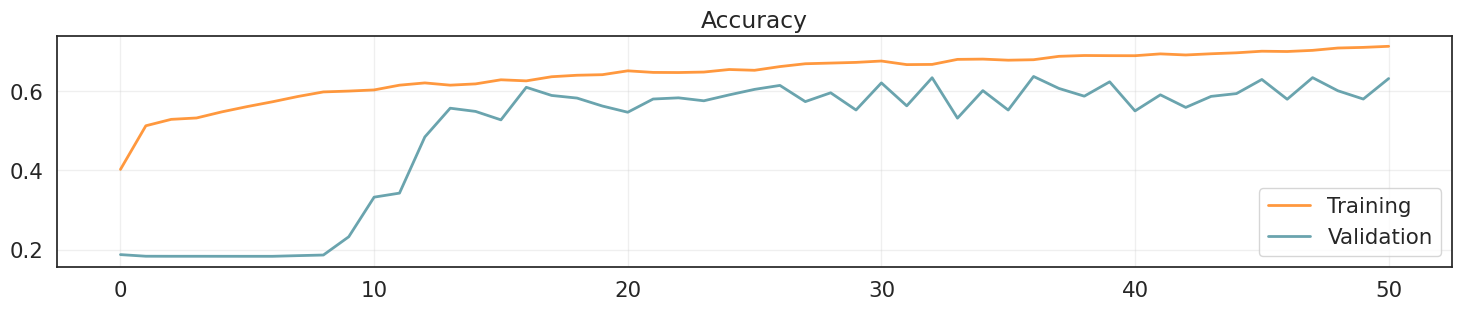

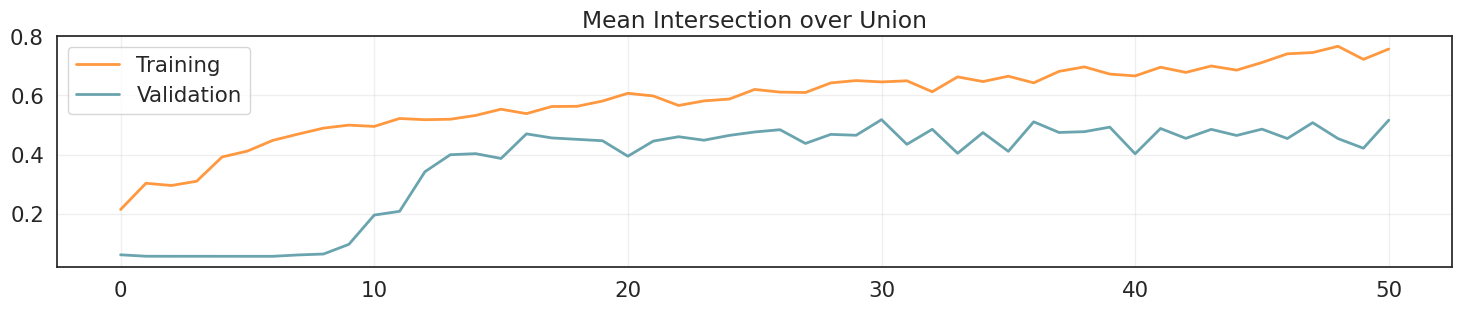

In [16]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [17]:
# path
model_path = "/kaggle/working/UNet_51.8.keras"

# Load the model
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [18]:
model.compile(optimizer="adam", 
               loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8), 
              metrics=["accuracy", 
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])


In [19]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_our_test, y_our_test, verbose=1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}\nMean Over Union: {test_mean_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.6050 - loss: 0.1935 - mean_iou: 0.5375
Loss: 0.19382420182228088
Accuracy: 0.6110900640487671
Mean Over Union: 0.5016472339630127


In [20]:
def calculate_class_iou(y_true, y_pred, num_classes):
    class_iou = {}

    for class_idx in range(num_classes):
        # Crea una maschera binaria per la classe
        true_mask = (y_true == class_idx).astype(int)
        pred_mask = (y_pred == class_idx).astype(int)

        # Calcola l'intersezione e l'unione
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Calcola IoU, evitando la divisione per zero
        iou = intersection / union if union > 0 else 0.0
        class_iou[class_idx] = iou

    return class_iou

In [21]:
# Compute the prediction
y_pred = model.predict(X_our_test, batch_size=10)
y_pred_labels = tf.math.argmax(y_pred, axis=-1).numpy()

# Compute IoU per class
iou_per_class = calculate_class_iou(y_our_test, y_pred_labels, num_classes)

# Print the results
for class_idx, iou in iou_per_class.items():
    print(f"Class {class_idx}: IoU = {round(iou, 4)}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Class 0: IoU = 0.0
Class 1: IoU = 0.5929
Class 2: IoU = 0.4621
Class 3: IoU = 0.5555
Class 4: IoU = 0.0056


In [22]:
def calculate_metrics_per_class(y_true, y_pred, num_classes):
    metrics = {}

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        true_binary = (y_true == class_idx).flatten()
        pred_binary = (y_pred == class_idx).flatten()

        # Compute precision, recall, and F1-score
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)

        # Store the metrics for the current class
        metrics[class_idx] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }

    return metrics

In [23]:
# Compute metrics for each class
metrics_per_class = calculate_metrics_per_class(y_our_test, y_pred_labels, num_classes)

# Print the results for each class
for class_idx, metrics in metrics_per_class.items():
    print(f"Class {class_idx}:")
    print(f"  Precision = {round(metrics['Precision'], 4)}")
    print(f"  Recall = {round(metrics['Recall'], 4)}")
    print(f"  F1-score = {round(metrics['F1-score'], 4)}")

Class 0:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0
Class 1:
  Precision = 0.6762
  Recall = 0.8281
  F1-score = 0.7445
Class 2:
  Precision = 0.5423
  Recall = 0.7574
  F1-score = 0.6321
Class 3:
  Precision = 0.5964
  Recall = 0.89
  F1-score = 0.7142
Class 4:
  Precision = 0.0164
  Recall = 0.0085
  F1-score = 0.0111


## 📊 Prepare Your Submission


In [24]:
# Percorso del file del modello
model_path = "/kaggle/working/UNet_51.8.keras"

# Carica il modello
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [25]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Predictions shape: (10022, 64, 128)


In [26]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [27]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Convert predictions to DataFrame
submission_df.to_csv(f"/kaggle/working/{submission_filename}", index=False)

print(f"Submission file saved: {submission_filename}")

Submission file saved: submission_UNet_51.8.csv
